Fixing from notes. See page 85. redoing order of summation. 

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import itertools
from mpl_toolkits.mplot3d import Axes3D
from RayTraceFun_forDetTest import *
from PossibleFunctionsDetTest import *
from BackgroundDetTest import *
from random import uniform
import random
import matplotlib
import pickle
import time #to save figs automatically time.strftime("%Y_%m_%d_%s")
#%matplotlib auto

In [14]:
def OFDM(Rays,y): #output from detector with mirror at Y
    Rayf = []
    for i in range(len(Rays)):
        Paths = [TTTTioM,RRRRioM,TTRRioM,RTTRioM,RTRTioM,TRRTioM,RRTTioM,TRTRioM]
        Ri = Rays[i]
        for j in range(8):
            origin = (0,y,0)
            out = Paths[j](Ri,p1,p2,p3,p4,origin)
            if out is not None:
                Rayf.append(out)
    return Rayf

def checkoutraysM(Rays,center,r): #RAYS THAT HIT DETECTOR
    GRays = []
    for i in range(len(Rays)):
        det = PLINTzS(80.,Rays[i][2],Rays[i][3])
        Rays[i][2] = det
        Rays[i][0] = Rays[i][0] + np.pi #reflection changes polarization
        d = ((det[0]-center[0])**2) + ((det[1]-center[1])**2) #if it is within detector
        if d <= r**2: 
            GRays.append(Rays[i])
    return GRays

def RunRaysMi(Rays,y): #just give number of rays to be run through this FTS at a specific y!
    Rayf = OFDM(Rays,y)
    G= checkoutraysM(Rayf,[160.375,-113],7.9375) # GOOD RAYS ONLY 
    Gtestsorted = sortgrid(G)
    Regions = regionalize(Gtestsorted)
    return Gtestsorted,Regions


def makeraysiFIXED(n,r):
    sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL 
    sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(r,sourcepointorigin,sourcethet,n) # SOURCE
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    for i in range(n):
        Rays[i][2] = sourcepointorigin
        v1x,v1y,v1z = transformLG(0.,0.,1,originG,sourcethet)
        v2 = sepop(v1x,v1y,v1z)
        Rays[i][3]=v2
    return Rays

def SumjRegionsMi_TestG(Rays,y): #ALSO INCORPORATES PHASE
    OutRays,regions=RunRaysMi(Rays,y)
    Regions = list(regions)
    jx,jy = gridlines(7.9375,[160.375,-113],200)
    LamdAll = np.linspace(1, 10,300) #possible wavelengths (30-300 Ghz), steps of 1Ghz
    DetTot = []
    for j in range(len(regions)):
        ExTot = []
        EyTot = []
        for i in range(len(Regions[j])): #All rays in region j
            #ExTot = []
            #EyTot = []
            if i != 0 and i != 1:
                JRegion = Regions[j]
                o,p = JRegion[0],JRegion[1] # jx and jy defining the jth region
                Raym = OutRays[JRegion[i]] #ith ray in the jth region
                if o != len(jx)-1 and p !=len(jy)-1:
                    #w = 1
                    w = gaussian3d(Raym[2][0],Raym[2][1],.4,(jx[o]+jx[o+1])/2,(jy[p]+jy[p+1])/2)
                else: 
                    w = 0 #(skipping gaussian)
                #Raym[1] is intensity!!! #split into x and y components of AMPLITUDE field
                #w = 1
                I = Raym[1]
                thet = Raym[0]
                Ex1,Ey1 = w*np.sqrt(I)*np.cos(thet),w*np.sqrt(I)*np.sin(thet) #multiplied by gaussian
                #only one frequency 
                Lamd = 3.3
                phase = np.exp(1j*(Raym[4]%Lamd)*2*np.pi/Lamd)
                #phase = np.exp(2*np.pi*1j*Raym[4]/Lamd)
                Ex = Ex1*phase
                Ey = Ey1*phase
                ExTot.append(Ex)
                EyTot.append(Ey)
        Ij = (np.sum(ExTot)*np.sum(ExTot).conjugate()) + (np.sum(EyTot)*np.sum(EyTot).conjugate())
        DetTot.append(Ij.real)
    return np.sum(DetTot)

def RunFTSLimiStraightTest(n,r,div,Lim):
    Power = []
    Delay = []
    Rays = makeraysiFIXED(n,r)
    for y in np.linspace(-int(Lim),int(Lim),div):
        I = SumjRegionsMi_TestG(Rays,y)
        Power.append(I)
        Delay.append(y)
    return Power,Delay 

#is normalized now
def Airygaussian3dNORM(x,y,sig,mux,muy): #assuming is symmetric, making peak = 1
   # A = 1
    A = (1/((sig**3)*(2*np.pi)**(3/2)))
    return A*np.exp(-(((x-mux)**2)/(2*sig**2) + ((y-muy)**2)/(2*sig**2)))

def Airygaussian3d(x,y,sig,mux,muy): #assuming is symmetric, making peak = 1
    A = 1
    #A = (1/((sig**3)*(2*np.pi)**(3/2)))
    return A*np.exp(-(((x-mux)**2)/(2*sig**2) + ((y-muy)**2)/(2*sig**2)))

#given LAST ray and its wavelength, return sig, mux and muy to then be used in gaussian  
#see pg 79 for more details(approx of airy func)
def MakeGaussian(Ray,Lamd):
    mux,muy = Ray[2][0],Ray[2][1] #center of gaussian is intersection point
    width = 3.0988*Lamd
    sig = width/3
    return sig,mux,muy

#given the two positions of the last rays and wavelength, returns percentage of overlap (out of 1)
def gaussoverlap(Ray1,Ray2,Lamd):
    sig1,mux1,muy1 = MakeGaussian(Ray1,Lamd)
    sig2,mux2,muy2 = MakeGaussian(Ray2,Lamd)
    p1 = [mux1,muy1,80.] #points in 3d in GLOBAL coordinates
    p2 = [mux2,muy2,80.]
    MDValue = dist(p1,p2)
    MD = [0,.25,.5,.75,1,1.1,1.2,1.3,1.5,1.7,1.9,2.1,2.3,2.6,2.9,3.4,3.7,3.9] #mean difference
    GP = [1,.9,.8,.7,.62,.6,.55,.5,.45,.4,.35,.3,.25,.2,.15,.1,.07,.05] #Gaussian Percent
    idx = (np.abs(MD-MDValue)).argmin() #index number in array for closest value
    return GP[idx]

#find CENTER of each pixel now as [x,y]
def MakePixels(jx,jy):
    pix = []
    for o in range(len(jx)-1):
        for p in range(len(jy)-1):
            r = 7.9375
            xpix,ypix= (jx[o]+jx[o+1])/2,(jy[p]+jy[p+1])/2
            d = np.sqrt((xpix-160.375)**2 + ((ypix-(-113))**2))
            if d <= r: 
                pix.append([xpix,ypix])
    return pix
def makerays(sourcepointorigin,sourcethet,r,n):
    #sourcepointorigin = [-160.375,-113.,-80.0] #LOCAL
    #sourcethet = [0.,0.,0.] #SHOT STRAIGHT UP
    sourcepoints = specsource(r,sourcepointorigin,sourcethet,n) # SOURCE
    Rays = FSRay(n,sourcepoints, sourcethet,origin10)
    for i in range(n):
        Rays[i][2] = sourcepointorigin
        v1x,v1y,v1z = transformLG(0.,0.,1,originG,sourcethet)
        v2 = sepop(v1x,v1y,v1z)
        Rays[i][3]=v2
    return Rays

In [15]:
n = 10
r = 7.9375
st = [0.,0.,0.] #SHOT STRAIGHT UP
spo = [-160.375,-113.,-80.0]
makerays(spo,st,r,n) 

[[0.8443773169648228, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [5.7470723962609425, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [4.023438745391314, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [2.1488719846029256, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [5.008803061065298, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [4.572678118993854, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [2.633031457079143, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [5.466654936567131, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [1.7624220382790965, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0],
 [3.354498376128962, 1.0, [-160.375, -113.0, -80.0], [0.0, 0.0, 1.0], 0]]

In [12]:
#TESTING OUTPUT/DECOHERENCE
DetPoint= []
Run=1
if Run==1:
    n = 10
    r = 7.9375
    st = [0.,0.,0.] #SHOT STRAIGHT UP
    Lamd = 3.3
    Nsize = 256
    spo = [-160.375,-113.,-80.0]
    Rays = makerays(spo,st,r,n) 
    for i in range(10):
        print(Rays[i][2])
    #jx,jy = gridlines(7.9375,[160.375,-113],200) #these are now the PIXELS
    #Pix = MakePixels(jx,jy) #center of each pixel
    #y = 18
    #if y ==18:
    #for y in np.linspace(-18,18,int(Nsize)):
        #OutRays,regions=RunRaysMi(Rays,y) 
        #for i in range(len(OutRays)):
            #DetPoint.append(PLINTzS(80.,OutRays[i][2],OutRays[i][3]))
        

#print('Done')

IndexError: tuple index out of range

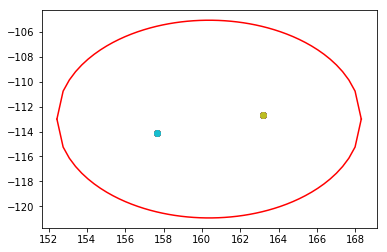

In [8]:
x,yp,yn = circle([160.375,-113],7.9375)
pl.plot(x,yp, color = 'red')
pl.plot(x,yn, color = 'red',label = 'r = 7.9375mm')
for i in range(len(DetPoint)):
    pl.scatter(DetPoint[i][0],DetPoint[i][1])
pl.show()